In [ ]:
from src.resplit import resplit_dataset
from src.load_images import load_single_image,load_images_masks,load_single_mask
from src.plot import display_image_and_mask
from src.augment import augment_dataset
from src.model import unet_model,filter_pixels
from src.plot import plot_metrics
from src.metrics import f1_score,calculate_precision_recall,calculate_pixel_accuracy,calculate_iou
import matplotlib.pyplot as plt
import keras
import seaborn as sns
import numpy as np


In [2]:
data_path: str = "/home/recabet/.cache/kagglehub/datasets/atilol/aerialimageryforroofsegmentation/versions/9"
local_path: str = "/home/recabet/Coding/AerialSegmentation"

In [3]:
resplit_dataset(data_path, local_path)

In [4]:
test_path: str = f"{local_path}/test"
train_path: str = f"{local_path}/train"
val_path: str = f"{local_path}/val"

In [5]:
train_images_path = f"{train_path}/images"
val_images_path = f"{val_path}/images"
test_images_path = f"{test_path}/images"
train_labels_path = f"{train_path}/labels"
val_labels_path = f"{val_path}/labels"
test_labels_path = f"{test_path}/labels"

In [6]:
image_97_path: str = f"{train_path}/images/christchurch_97.tif"
image_110_path: str = f"{train_path}/images/christchurch_110.tif"
image_135_path: str = f"{train_path}/images/christchurch_135.tif"
image_210_path: str = f"{train_path}/images/christchurch_210.tif"
image_275_path: str = f"{train_path}/images/christchurch_275.tif"
label_97_path: str = f"{train_path}/labels/christchurch_97_vis.tif"
label_110_path: str = f"{train_path}/labels/christchurch_110_vis.tif"
label_135_path: str = f"{train_path}/labels/christchurch_135_vis.tif"
label_210_path: str = f"{train_path}/labels/christchurch_210_vis.tif"
label_275_path: str = f"{train_path}/labels/christchurch_275_vis.tif"

In [7]:
image_97 = load_single_image(image_97_path)
image_110 = load_single_image(image_110_path)
image_135 = load_single_image(image_135_path)
image_210 = load_single_image(image_210_path)
image_275 = load_single_image(image_275_path)
mask_97 = load_single_mask(label_97_path)
mask_110 = load_single_mask(label_110_path)
mask_135 = load_single_mask(label_135_path)
mask_210 = load_single_mask(label_210_path)
mask_275= load_single_mask(label_275_path)

/home/recabet/anaconda3/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


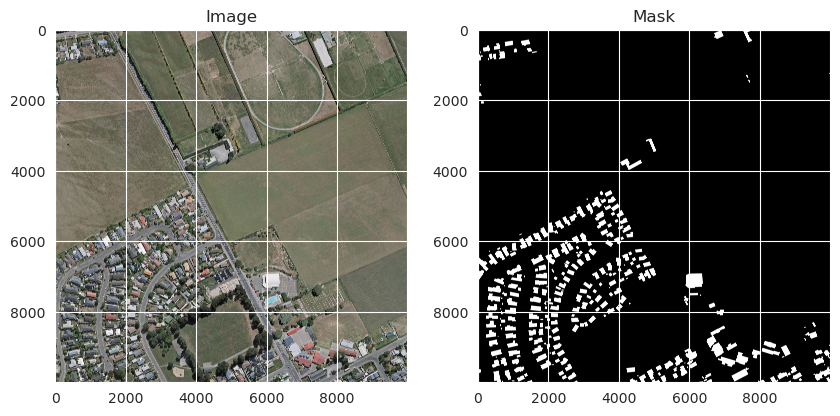

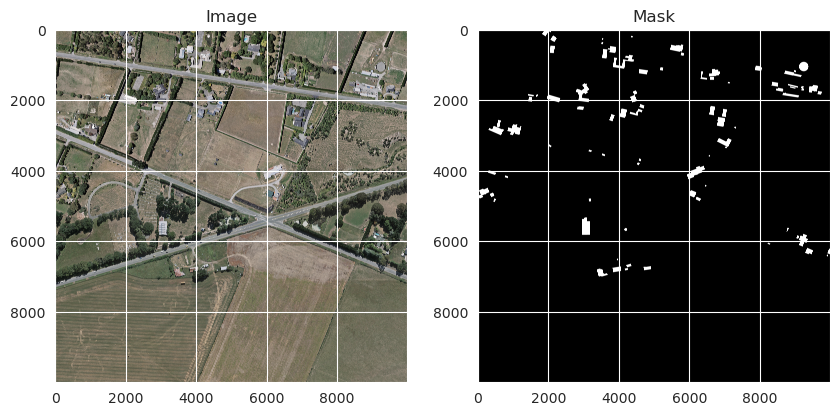

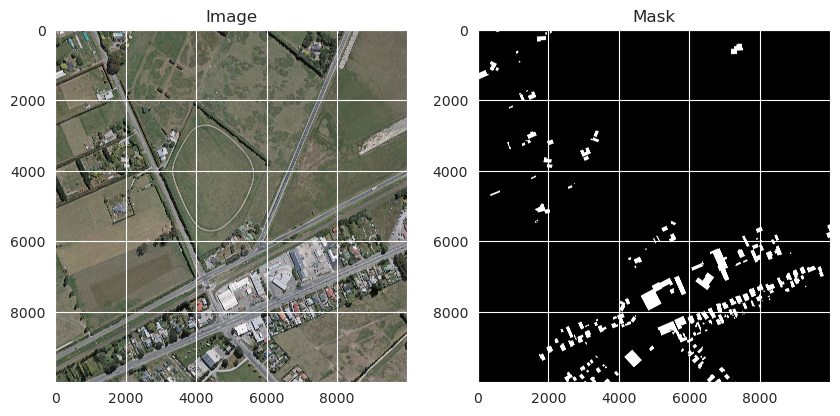

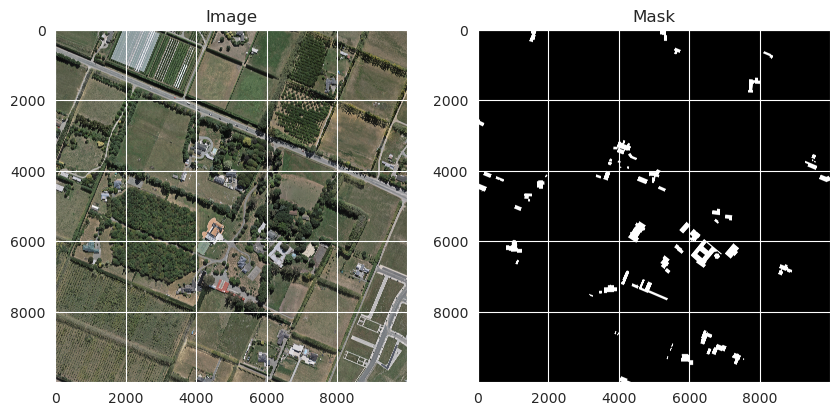

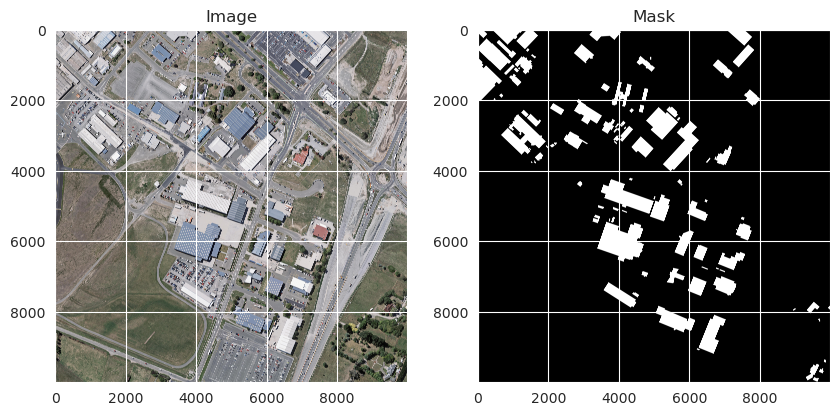

In [8]:
display_image_and_mask(image_97, mask_97)
display_image_and_mask(image_110, mask_110)
display_image_and_mask(image_135, mask_135)
display_image_and_mask(image_210, mask_210)
display_image_and_mask(image_275, mask_275)

In [9]:
train_images, train_labels = load_images_masks(train_images_path, train_labels_path, img_size=(128, 128),remove_black_masks=True)
val_images, val_labels = load_images_masks(val_images_path, val_labels_path, img_size=(128, 128))
test_images, test_labels = load_images_masks(test_images_path, test_labels_path, img_size=(128, 128))

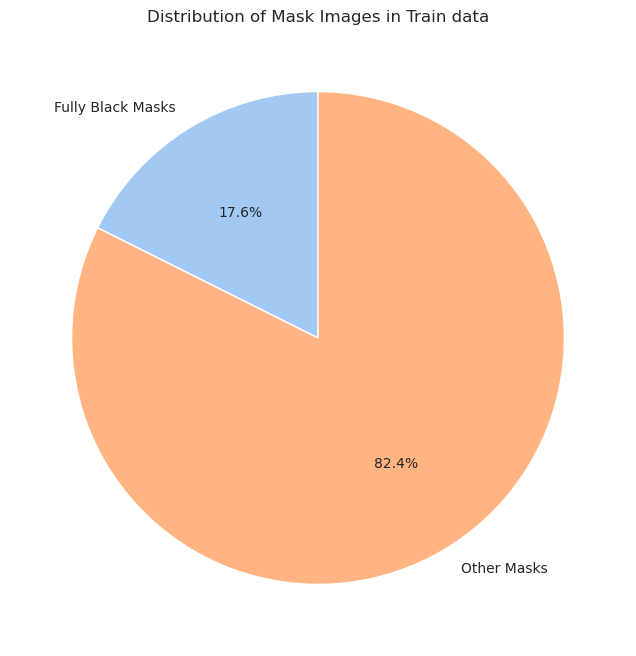

In [10]:
total_images = 732
non_black_masks = 603
black_masks = total_images - non_black_masks

labels = ['Fully Black Masks', 'Other Masks']
sizes = [black_masks, non_black_masks]
colors = ['black', 'gray']

sns_colors = sns.color_palette("pastel", 2)

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns_colors)
plt.title("Distribution of Mask Images in Train data")
plt.show()

<BarContainer object of 2 artists>

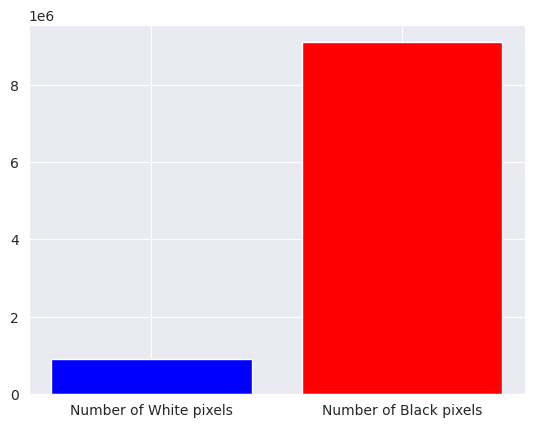

In [11]:
white_pixel_count:int = sum([np.sum(i) for i in train_labels])
black_pixel_count:int = sum([np.sum(i == 0) for i in train_labels])

plt.bar(
        ["Number of White pixels", "Number of Black pixels"],
        [white_pixel_count, black_pixel_count],
        color=["blue","red"]
        )

In [12]:
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)
print("Validation Images Shape:", val_images.shape)
print("Validation Labels Shape:", val_labels.shape)

Train Images Shape: (612, 128, 128, 3)
Train Labels Shape: (612, 128, 128, 1)
Test Images Shape: (105, 128, 128, 3)
Test Labels Shape: (105, 128, 128, 1)
Validation Images Shape: (209, 128, 128, 3)
Validation Labels Shape: (209, 128, 128, 1)


In [13]:
generated_train= augment_dataset(train_images, train_labels)
generated_val = augment_dataset(val_images, val_labels)

2024-11-20 18:36:17.680803: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("models/best_unet_model.keras",
                                    save_best_only=True,
                                    monitor="val_loss"),

    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=10,
                                  restore_best_weights=True),

    keras.callbacks.ReduceLROnPlateau(monitor=
                                      "val_loss",
                                      factor=0.2,
                                      patience=5,
                                      verbose=1),
]


model = unet_model((128, 128, 3))

history = model.fit(
    generated_train,
    batch_size=1,
    epochs=10,
    validation_data = generated_val,
    callbacks=callbacks
)

Epoch 1/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.9019 - binary_io_u: 0.4527 - loss: 0.4845 - precision: 0.0170 - recall: 0.0034 - val_accuracy: 0.9276 - val_binary_io_u: 0.4648 - val_loss: 0.1814 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.9115 - binary_io_u: 0.4947 - loss: 0.2050 - precision: 0.6032 - recall: 0.0809 - val_accuracy: 0.9311 - val_binary_io_u: 0.4971 - val_loss: 0.1577 - val_precision: 0.8291 - val_recall: 0.0611 - learning_rate: 0.0010
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.9145 - binary_io_u: 0.5684 - loss: 0.1924 - precision: 0.6427 - recall: 0.2535 - val_accuracy: 0.9370 - val_binary_io_u: 0.6574 - val_loss: 0.1509 - val_precision: 0.5759 - val_recall: 0.5290 - learning_rate: 0.0010
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.9242 - binary_io_u: 0.6134 - loss: 0.1707 - precision: 0.6414 - recall: 0.36

In [15]:
test_results = model.evaluate(test_images, test_labels)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9476 - binary_io_u: 0.7205 - loss: 0.1247 - precision: 0.7900 - recall: 0.5701


In [16]:
predictions=model.predict(test_images)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


In [17]:
threshold:float = 0.3
filter_pixels(threshold, predictions)

In [18]:
precision = history.history.get('precision', [])
recall = history.history.get('recall', [])
accuracy = history.history.get('accuracy', [])
iou = history.history.get('binary_io_u', [])
loss=history.history.get('loss', [])
val_precision = history.history.get('val_precision', [])
val_recall = history.history.get('val_recall', [])
val_accuracy = history.history.get('val_accuracy', [])
val_iou = history.history.get('val_binary_io_u', [])
val_loss=history.history.get('val_loss', [])

f1 = f1_score(precision, recall)
val_f1 = f1_score(val_precision, val_recall)


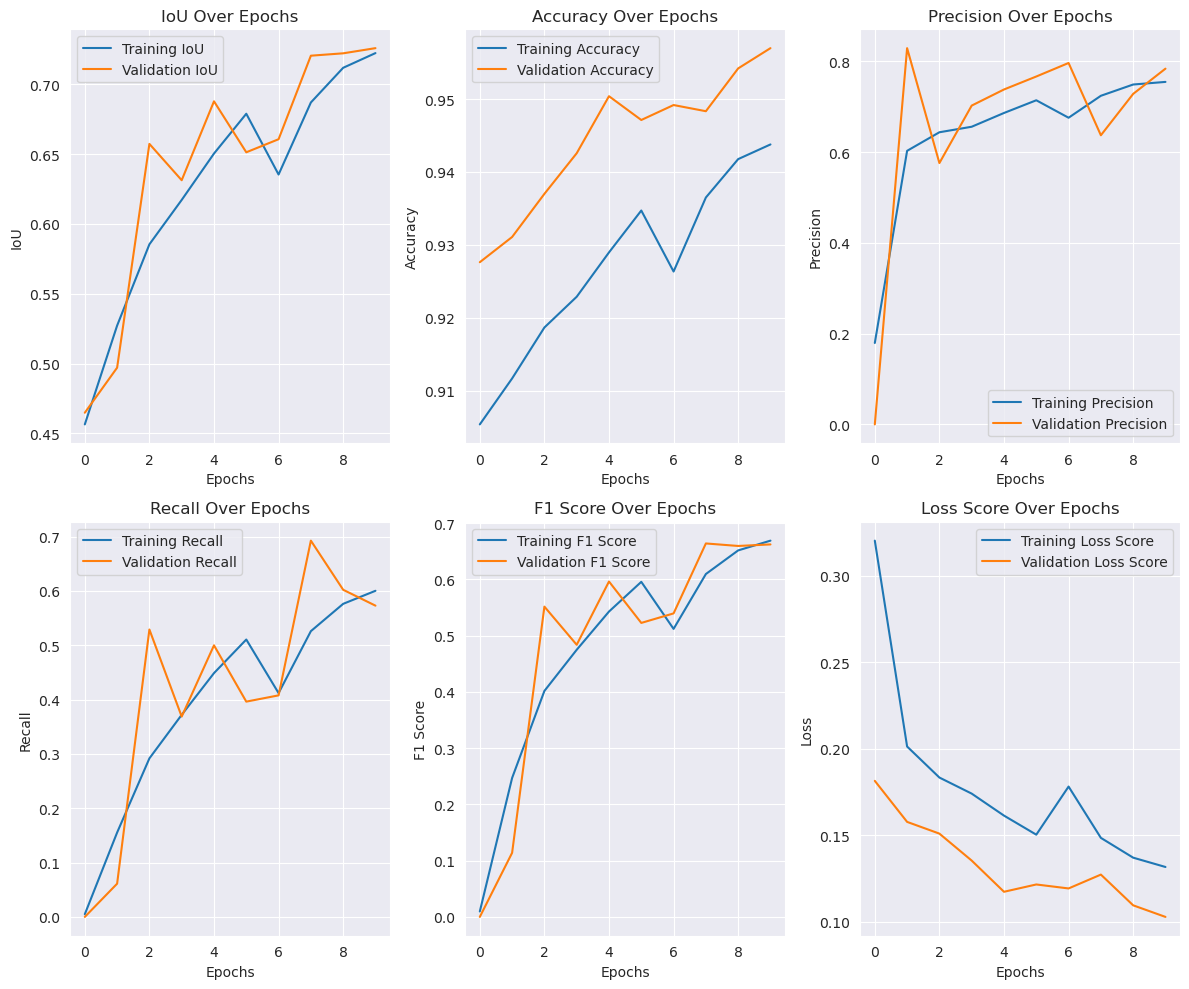

In [19]:
plot_metrics(iou,
            val_iou,
            accuracy,
            val_accuracy,
            precision,
            val_precision,
            recall,
            val_recall,
            f1,
            val_f1,
            loss,
            val_loss)

In [20]:
print(f"train f1: {f1[9]}")
print(f"val f1: {val_f1[9]}")

train f1: 0.6687074342899977
val f1: 0.6620165762060717


In [21]:
threshold = 0.6
filter_pixels(threshold, predictions)

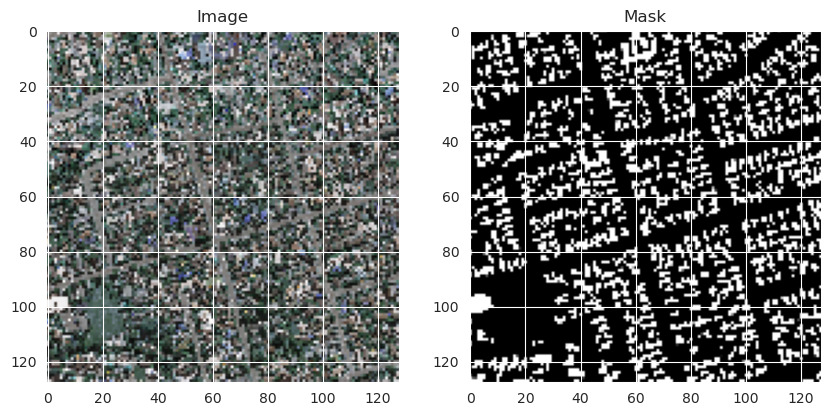

Text(0.5, 1.0, 'Model Prediction')

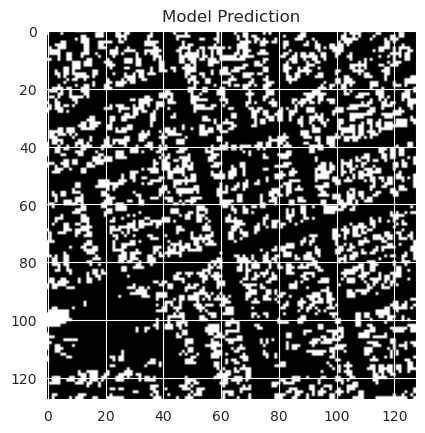

In [22]:
display_image_and_mask(test_images[0],test_labels[0])
plt.imshow(predictions[0],cmap='gray')
plt.title('Model Prediction')

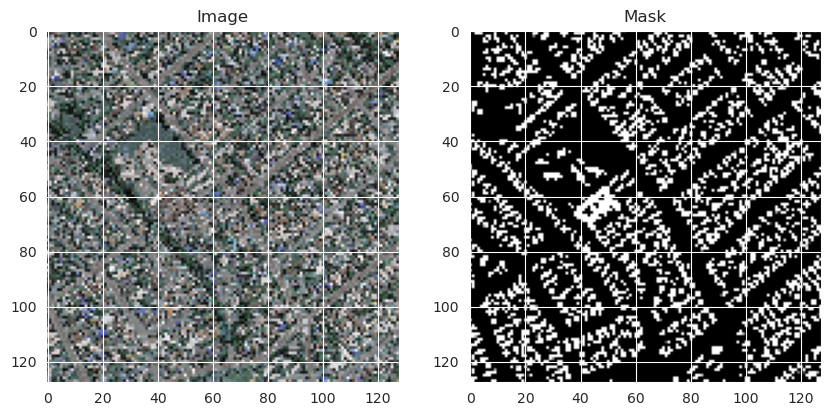

Text(0.5, 1.0, 'Model Prediction')

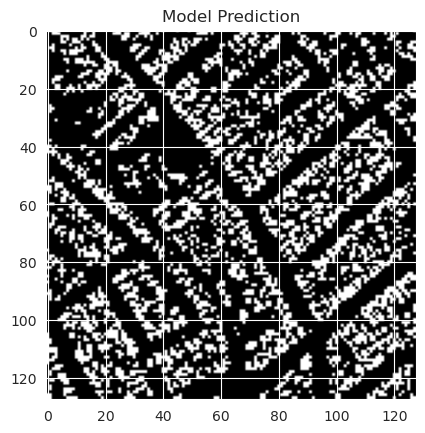

In [23]:
display_image_and_mask(test_images[1],test_labels[1])
plt.imshow(predictions[1],cmap='gray')
plt.title('Model Prediction')

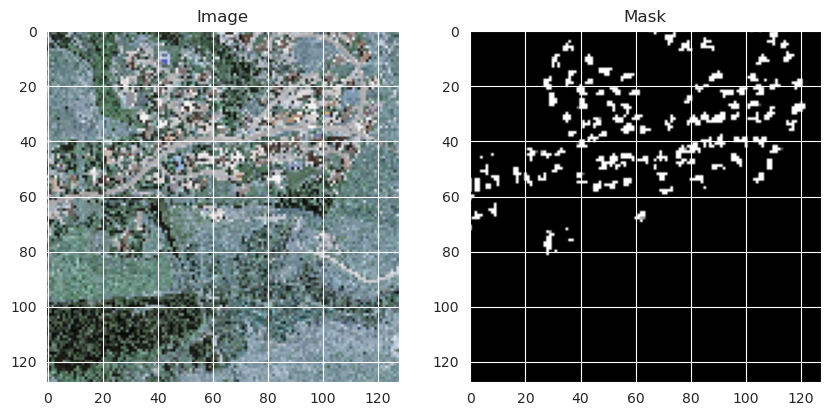

Text(0.5, 1.0, 'Model Prediction')

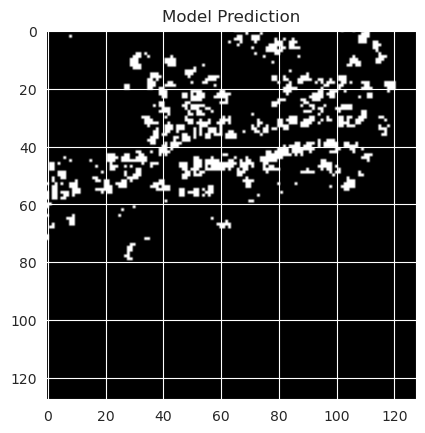

In [24]:
display_image_and_mask(test_images[2],test_labels[2])
plt.imshow(predictions[2],cmap='gray')
plt.title('Model Prediction')

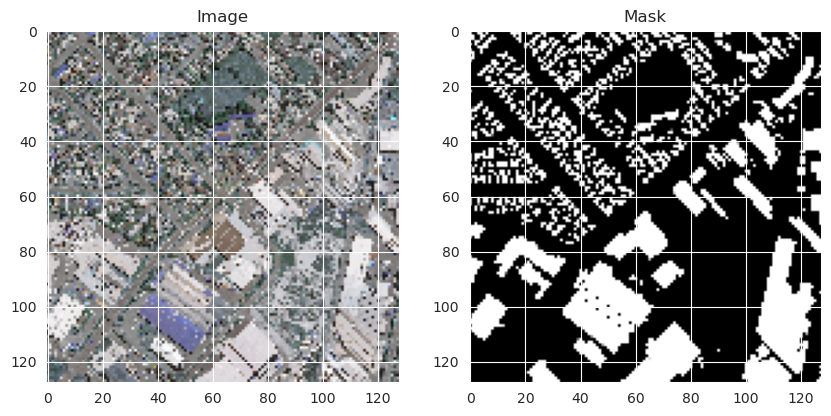

Text(0.5, 1.0, 'Model Prediction')

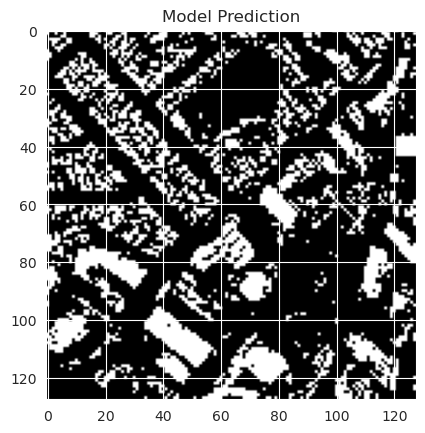

In [25]:
display_image_and_mask(test_images[3],test_labels[3])
plt.imshow(predictions[3],cmap='gray')
plt.title('Model Prediction')

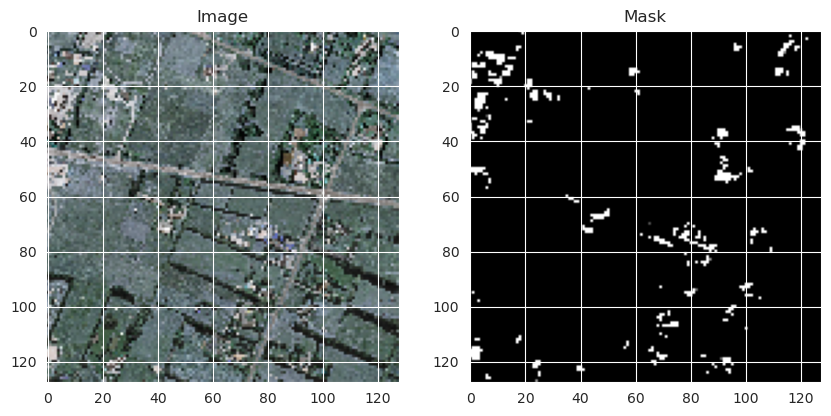

Text(0.5, 1.0, 'Model Prediction')

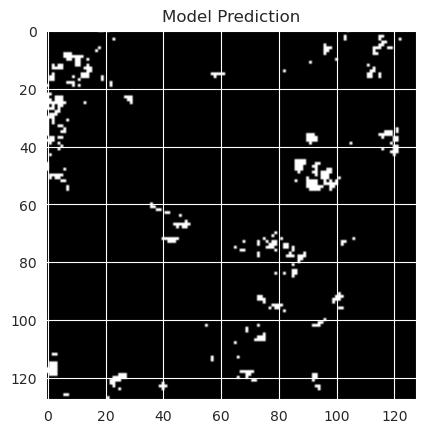

In [26]:
display_image_and_mask(test_images[4],test_labels[4])
plt.imshow(predictions[4],cmap='gray')
plt.title('Model Prediction')

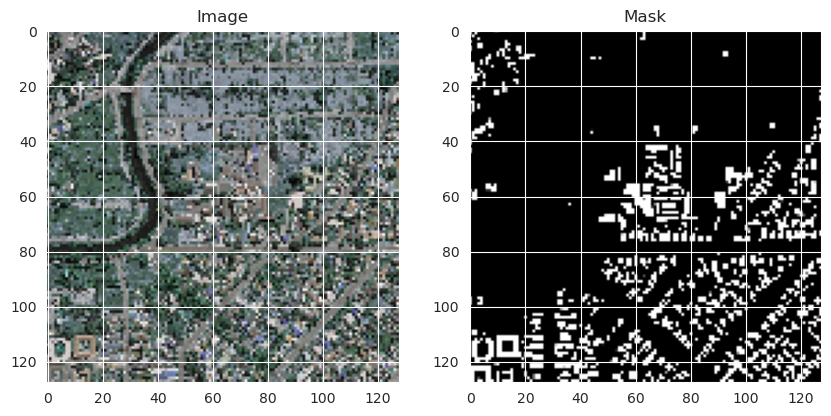

Text(0.5, 1.0, 'Model Prediction')

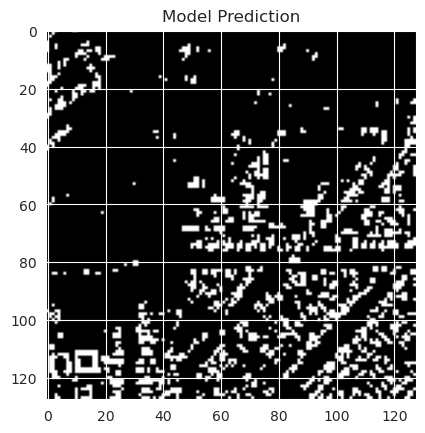

In [27]:
display_image_and_mask(test_images[5],test_labels[5])
plt.imshow(predictions[5],cmap='gray')
plt.title('Model Prediction')

In [48]:
iou_white,iou_black=calculate_iou(predictions,test_labels)

print("iou white:", round(iou_white,2))
print("iou black:", round(iou_black,2))

iou white: 0.55
iou black: 0.95


In [49]:
white_pixel_accuracy,black_pixel_accuracy=calculate_pixel_accuracy(predictions,test_labels)

print("white pixel accuracy:", round(white_pixel_accuracy,2))
print("black pixel accuracy:", round(black_pixel_accuracy,2))

white pixel accuracy: 0.75
black pixel accuracy: 0.97


In [51]:
precision_white, recall_white, precision_black, recall_black=calculate_precision_recall(predictions, test_labels)

print("white pixel precision:", round(precision_white,2))
print("black pixel precision:", round(precision_black,2))
print("white pixel recall:", round(recall_white,2))
print("black pixel recall:", round(recall_black,2))

white pixel precision: 0.67
black pixel precision: 0.98
white pixel recall: 0.75
black pixel recall: 0.97


In [54]:
f1_score_white=2*precision_white*recall_white/(precision_white+recall_white)
f1_score_black=2*precision_black*precision_black/(precision_black+precision_black)
print("f1 score white:", round(f1_score_white,2))
print("f1 score black:", round(f1_score_black,2))

f1 score white: 0.71
f1 score black: 0.98
